# Resume Classification

In [1]:
# Installing tika - a server which is written in JAVA for text extracting ( JAVA must be installed in the device)
#!pip install tika

In [1]:
# Importing all required packages
import os
import re
import string
from tika import parser

import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

import pickle

import warnings
warnings.filterwarnings('ignore')

## Extracting Text

In [2]:
# Function to parse the data from the file using tika package

def extract_text(file_path):
    parsed = parser.from_file(file_path)
    return parsed["content"]

In [3]:
# listing the subfolders available inside the main folder
dataset_path = 'datasets/Resumes_Docx/'
folder_list = os.listdir(dataset_path)
folder_list

['Peoplesoft Resume', 'React Developer', 'SQL Developer', 'workday']

In [4]:
# To save the extracted data and role in a list
raw_text = []

# Reading through the dataset and adding to the list
for role in folder_list:
    for eachFile in os.listdir(dataset_path+role):
        text = re.sub(r'^\n+', '', extract_text(dataset_path+role+"/"+eachFile), count=1) # Extracting the text for the particular file
         # Creating a Dictionary containing 2 key&value pairs for dataframe creation
        new_row = {'job_role': role, 'text': text}
        raw_text.append(new_row)

In [5]:
# Creating the DataFrame
resume_dataset = pd.DataFrame(data= raw_text, columns=['job_role', 'text'])
resume_dataset

,job_role,text
0,Peoplesoft Resume,Anubhav Kumar Singh\t\t\nCore Competencies:\...
1,Peoplesoft Resume,Profile Summary:\n\n\n\n\n\n\n\n\n\n\n· 7+ yea...
2,Peoplesoft Resume,PeopleSoft Database Administrator\n\nPeopleSof...
3,Peoplesoft Resume,Classification: Internal\n\nMurali\n\nExperien...
4,Peoplesoft Resume,"Priyanka Ramadoss\n61/46, MountPleasant, \n\nC..."
...,...,...
74,workday,Workday Integration Consultant\n\nName ...
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...
76,workday,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...
77,workday,Mathu Kumaran\n\n \n\nVenkateswarlu.B\n\n\n\n\...


In [6]:
#Checking the raw data
print(resume_dataset['text'][4])

Priyanka Ramadoss
61/46, MountPleasant, 

Coonoor

The Nilgiris- 643102                                                                                            

Career Objective

To excel as a software professional by working in a learning and challenging environment and utilize the skills and knowledge through diligence, dedication and ensure maximum contribution to the growth of the organization I work for.

Profile Summary
An Adept IT professional with 4.11 years (September 2016 - present) of experience as Peoplesoft Admin with Accenture
Professional Summary
PeopleSoft Administrator (September 2016-Present)

· Experience in PeopleSoft Administration for Finance application.

· Proficient in creating and configuring PeopleSoft components like Web server, Application server and process schedulers.

· Active monitoring in Non production databases and applications.

· Knowledgeable on PeopleSoft migrations using application designer, data mover and taking compare reports and also mo

In [7]:
# Replacing the value Peoplesoft Resume with Peoplesoft
resume_dataset['job_role'] = resume_dataset['job_role'].replace('Peoplesoft Resume', 'Peoplesoft', regex=True)
resume_dataset['job_role'].value_counts()

job_role
React Developer    24
workday            21
Peoplesoft         20
SQL Developer      14
Name: count, dtype: int64

In [8]:
# Create a job_role count plot
fig = px.histogram(resume_dataset, x="job_role", color=resume_dataset['job_role'])

# Update the layout with labels and title
fig.update_layout(
    xaxis_title="Job Role",
    yaxis_title="No of Resumes",
    title="No of resumes according to Job Role"
)

fig.show()

## EDA

In [9]:
# Function to remove Emojies
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [10]:
# Function to clean the text of special and unwanted characters

def clean_text(text):
    cleaned_text = str(text)
    # Remove email-like addresses
    cleaned_text = re.sub(r'\S+@\S+', '', cleaned_text)
    # Remove links
    cleaned_text = re.sub(r'\S+\.com\S*', '', cleaned_text)
    # Remove URLS
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)
    # Remove Emojis
    cleaned_text = deEmojify(cleaned_text)
    # Remove images
    cleaned_text = re.sub(r'\b\w+\.(png|jpg|jpeg)\b', '', text)
    # Removing the escape characters
    cleaned_text = re.sub(r'\\.', '', cleaned_text)
    # Removing bullets
    cleaned_text = re.sub(r' · ', '', cleaned_text)
    # Remove all the non-alpha symbols
    cleaned_text = re.sub(r'[^a-zA-Z]',' ',cleaned_text)
    # Replace multiple spaces with a single space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # Removing 2 character word
    cleaned_text = re.sub(r'\b([a-zA-Z])\1\b', "", cleaned_text)
    # Removing single character word
    cleaned_text = re.sub(r'\b[a-zA-Z]\b', "", cleaned_text)
    # Converting to the lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text.strip()

In [11]:
# Checking if the clean_text() function performs accurately
test_cleaning = clean_text(resume_dataset['text'][4])
print(test_cleaning)

priyanka ramadoss mountpleasant coonoor the nilgiris career objective to excel as  software professional by working in  learning and challenging environment and utilize the skills and knowledge through diligence dedication and ensure maximum contribution to the growth of the organization  work for profile summary an adept it professional with years september present of experience as peoplesoft admin with accenture professional summary peoplesoft administrator september present experience in peoplesoft administration for finance application proficient in creating and configuring peoplesoft components like web server application server and process schedulers active monitoring in non production databases and applications knowledgeable on peoplesoft migrations using application designer data mover and taking compare reports and also moving the codes from dev to test and production environments usage of hp ppm tool as well to perform peoplesoft migrations and compare report generation full 

In [12]:
# Applying clean_text() function to the Raw text and saving it to the new column
resume_dataset['Cleaned_data'] = resume_dataset['text'].apply(clean_text)
resume_dataset

,job_role,text,Cleaned_data
0,Peoplesoft,Anubhav Kumar Singh\t\t\nCore Competencies:\...,anubhav kumar singh core competencies scriptin...
1,Peoplesoft,Profile Summary:\n\n\n\n\n\n\n\n\n\n\n· 7+ yea...,profile summary years of experience in impleme...
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...
3,Peoplesoft,Classification: Internal\n\nMurali\n\nExperien...,classification internal murali experience summ...
4,Peoplesoft,"Priyanka Ramadoss\n61/46, MountPleasant, \n\nC...",priyanka ramadoss mountpleasant coonoor the ni...
...,...,...,...
74,workday,Workday Integration Consultant\n\nName ...,workday integration consultant name sri krishn...
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seeking suitab...
76,workday,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...,workday hcm fcm name kumar role workday cons...
77,workday,Mathu Kumaran\n\n \n\nVenkateswarlu.B\n\n\n\n\...,mathu kumaran venkateswarlu workday consultan...


In [13]:
# Count the number of words in tthe text

def count_words_basic(text):
    # Split the text into words using whitespace as delimiter
    words = text.split()
    return len(words)

In [14]:
# Apply the count_words_basic function to the DataFrame
resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
resume_dataset

,job_role,text,Cleaned_data,No_of_words
0,Peoplesoft,Anubhav Kumar Singh\t\t\nCore Competencies:\...,anubhav kumar singh core competencies scriptin...,938
1,Peoplesoft,Profile Summary:\n\n\n\n\n\n\n\n\n\n\n· 7+ yea...,profile summary years of experience in impleme...,916
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...,767
3,Peoplesoft,Classification: Internal\n\nMurali\n\nExperien...,classification internal murali experience summ...,572
4,Peoplesoft,"Priyanka Ramadoss\n61/46, MountPleasant, \n\nC...",priyanka ramadoss mountpleasant coonoor the ni...,613
...,...,...,...,...
74,workday,Workday Integration Consultant\n\nName ...,workday integration consultant name sri krishn...,918
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seeking suitab...,874
76,workday,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...,workday hcm fcm name kumar role workday cons...,1125
77,workday,Mathu Kumaran\n\n \n\nVenkateswarlu.B\n\n\n\n\...,mathu kumaran venkateswarlu workday consultan...,867


In [15]:
# Load the SpaCy language model
nlp = spacy.load("en_core_web_sm")

# Function to do text normalization
def lemmatization(text):
    # Process the text
    doc = nlp(text)
    # Extract and lemmatize tokens
    lemmatized_tokens = [token.lemma_.strip() for token in doc]
    return ' '.join(lemmatized_tokens)

In [16]:
# Apply the lemmatization function to the DataFrame
resume_dataset['Cleaned_data'] = resume_dataset['Cleaned_data'].apply(lemmatization)

# Apply the count_words_basic function to the DataFrame
resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
resume_dataset

,job_role,text,Cleaned_data,No_of_words
0,Peoplesoft,Anubhav Kumar Singh\t\t\nCore Competencies:\...,anubhav kumar singh core competency script she...,939
1,Peoplesoft,Profile Summary:\n\n\n\n\n\n\n\n\n\n\n· 7+ yea...,profile summary year of experience in implemen...,916
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...,767
3,Peoplesoft,Classification: Internal\n\nMurali\n\nExperien...,classification internal murali experience summ...,572
4,Peoplesoft,"Priyanka Ramadoss\n61/46, MountPleasant, \n\nC...",priyanka ramadoss mountpleasant coonoor the ni...,613
...,...,...,...,...
74,workday,Workday Integration Consultant\n\nName ...,workday integration consultant name sri krishn...,918
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seek suitable ...,874
76,workday,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...,workday hcm fcm name kumar role workday consu...,1125
77,workday,Mathu Kumaran\n\n \n\nVenkateswarlu.B\n\n\n\n\...,mathu kumaran venkateswarlu workday consultan...,867


In [17]:
# download additional data resources for nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\malla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# Function removes stopwords from the text
def remove_stopwords(text):
    # Define stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text) # Tokenize the text
    filtered_text = [word.strip() for word in word_tokens if word.lower() not in stop_words] # Filter out stopwords

    return ' '.join(filtered_text)

In [19]:
# Apply the remove_stopwords function to the DataFrame
resume_dataset['Cleaned_data'] = resume_dataset['Cleaned_data'].apply(remove_stopwords)
resume_dataset

# Apply the count_words_basic function to the DataFrame
resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
resume_dataset

,job_role,text,Cleaned_data,No_of_words
0,Peoplesoft,Anubhav Kumar Singh\t\t\nCore Competencies:\...,anubhav kumar singh core competency script she...,747
1,Peoplesoft,Profile Summary:\n\n\n\n\n\n\n\n\n\n\n· 7+ yea...,profile summary year experience implement upgr...,724
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...,589
3,Peoplesoft,Classification: Internal\n\nMurali\n\nExperien...,classification internal murali experience summ...,454
4,Peoplesoft,"Priyanka Ramadoss\n61/46, MountPleasant, \n\nC...",priyanka ramadoss mountpleasant coonoor nilgir...,486
...,...,...,...,...
74,workday,Workday Integration Consultant\n\nName ...,workday integration consultant name sri krishn...,716
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seek suitable ...,668
76,workday,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...,workday hcm fcm name kumar role workday consul...,871
77,workday,Mathu Kumaran\n\n \n\nVenkateswarlu.B\n\n\n\n\...,mathu kumaran venkateswarlu workday consultant...,661


In [20]:
# Removing the follwing NER from the dataset

ner_categories =  ['PERSON','GPE','LOC','NORP', 'FAC','PRODUCT','EVENT','WORK_OF_ART','DATE','TIME','LANGUAGE','MONEY']   # https://dataknowsall.com/blog/ner.html
def remove_NER_categories(text):
    doc = nlp(text)
    # Identify named entities and remove names
    cleaned_text = " ".join([token.text for token in doc if not token.ent_type_ in ner_categories])
    return cleaned_text

In [21]:
# Apply the remove_names function to the DataFrame
resume_dataset['Cleaned_data'] = resume_dataset['Cleaned_data'].apply(remove_NER_categories)
resume_dataset

# Apply the count_words_basic function to the DataFrame
resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
resume_dataset

,job_role,text,Cleaned_data,No_of_words
0,Peoplesoft,Anubhav Kumar Singh\t\t\nCore Competencies:\...,core competency script shell scripting applica...,734
1,Peoplesoft,Profile Summary:\n\n\n\n\n\n\n\n\n\n\n· 7+ yea...,profile experience implement upgrading support...,693
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...,576
3,Peoplesoft,Classification: Internal\n\nMurali\n\nExperien...,classification internal murali experience summ...,444
4,Peoplesoft,"Priyanka Ramadoss\n61/46, MountPleasant, \n\nC...",priyanka ramadoss mountpleasant coonoor nilgir...,472
...,...,...,...,...
74,workday,Workday Integration Consultant\n\nName ...,workday integration consultant name sri krishn...,690
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seek suitable ...,639
76,workday,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...,workday hcm fcm name role workday consultant p...,841
77,workday,Mathu Kumaran\n\n \n\nVenkateswarlu.B\n\n\n\n\...,kumaran venkateswarlu experience experience im...,616


In [22]:
# function to Use regular expressions to find and remove words with less than 3 characters

def remove_short_words(text):

    cleaned_text = re.sub(r'\b\w{1,2}\b', '', text)

    # Remove any extra spaces created by the removal
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text


In [23]:
# Apply the remove_short_words function to the DataFrame
resume_dataset['Cleaned_data'] = resume_dataset['Cleaned_data'].apply(remove_short_words)
resume_dataset

# Apply the count_words_basic function to the DataFrame
resume_dataset['No_of_words'] = resume_dataset['Cleaned_data'].apply(count_words_basic)
resume_dataset

,job_role,text,Cleaned_data,No_of_words
0,Peoplesoft,Anubhav Kumar Singh\t\t\nCore Competencies:\...,core competency script shell scripting applica...,726
1,Peoplesoft,Profile Summary:\n\n\n\n\n\n\n\n\n\n\n· 7+ yea...,profile experience implement upgrading support...,687
2,Peoplesoft,PeopleSoft Database Administrator\n\nPeopleSof...,peoplesoft database administrator peoplesoft d...,561
3,Peoplesoft,Classification: Internal\n\nMurali\n\nExperien...,classification internal murali experience summ...,437
4,Peoplesoft,"Priyanka Ramadoss\n61/46, MountPleasant, \n\nC...",priyanka ramadoss mountpleasant coonoor nilgir...,465
...,...,...,...,...
74,workday,Workday Integration Consultant\n\nName ...,workday integration consultant name sri krishn...,686
75,workday,SRIKANTH (WORKDAY HCM CONSULTANT)\t ...,srikanth workday hcm consultant seek suitable ...,624
76,workday,WORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nRol...,workday hcm fcm name role workday consultant p...,822
77,workday,Mathu Kumaran\n\n \n\nVenkateswarlu.B\n\n\n\n\...,kumaran venkateswarlu experience experience im...,613


In [24]:
# Combine all words into a single list
complete_text = " ".join(text for text in resume_dataset.Cleaned_data)
all_words = complete_text.split(" ")

# Count Word Frequencies
word_freq = Counter(all_words)

# Convert to DataFrame for plotting
word_counts_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)


# Step 5: Create the Plot
fig = px.bar(word_counts_df[0:20], x='Word', y='Frequency', title='Word Frequency Count on entire dataset',
             labels={'Word': 'Word', 'Frequency': 'Frequency'},
             color='Frequency', color_continuous_scale='Viridis')

# Show the plot
fig.show()


In [25]:
# Plotting the word frequency according to the jon role

for each_role in resume_dataset['job_role'].unique().tolist():
    complete_text = " ".join(text for text in resume_dataset.Cleaned_data[resume_dataset['job_role'] == each_role])
    all_words = complete_text.split(" ")
    word_freq = Counter(all_words)
    word_counts_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    fig = px.bar(word_counts_df[0:20], x='Word', y='Frequency', title='Word Frequency Count on ' + each_role,
                labels={'Word': 'Word', 'Frequency': 'Frequency'},
                color='Frequency', color_continuous_scale='Viridis')
    fig.show()

In [26]:
# Combine all words into a single list
complete_text = " ".join(text for text in resume_dataset.Cleaned_data)

# Generate the word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(complete_text)

# Convert the word cloud to a NumPy array
wordcloud_image = wordcloud.to_array()

# Display the word cloud using Plotly
fig = px.imshow(wordcloud_image)
fig.update_layout(title="Word Cloud",
                  xaxis=dict(showgrid=False, showticklabels=False),
                  yaxis=dict(showgrid=False, showticklabels=False))

# Increase the size of the
fig.update_layout(width=1200, height=600)

# Show the plot
fig.show()


In [27]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english')

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(resume_dataset['Cleaned_data'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['job_role'] = resume_dataset['job_role']
# Display the TF-IDF features
tfidf_df

,abdul,ability,able,abreast,abs,absence,absent,abstract,abstraction,academic,...,yoga,yogi,yonder,young,yrs,zenefit,zero,zerozilla,zone,job_role
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Peoplesoft
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Peoplesoft
2,0.0,0.000000,0.0,0.072802,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Peoplesoft
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Peoplesoft
4,0.0,0.029942,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.073263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Peoplesoft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.029923,0.0,0.000000,0.0,0.076596,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,workday
75,0.0,0.030344,0.0,0.000000,0.0,0.135146,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,workday
76,0.0,0.000000,0.0,0.000000,0.0,0.042127,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,workday
77,0.0,0.028166,0.0,0.000000,0.0,0.072097,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,workday


In [ ]:
# taking a pickle dump of the tfidf_vectorizer
pickle.dump(tfidf_vectorizer, open("artifacts/tfidf_vectorizer.pkl", "wb"))

In [28]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Perform label encoding on the 'Fruit' column
tfidf_df['job_role'] = label_encoder.fit_transform(tfidf_df['job_role'] )

tfidf_df


,abdul,ability,able,abreast,abs,absence,absent,abstract,abstraction,academic,...,yoga,yogi,yonder,young,yrs,zenefit,zero,zerozilla,zone,job_role
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.072802,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.029942,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.073263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.029923,0.0,0.000000,0.0,0.076596,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
75,0.0,0.030344,0.0,0.000000,0.0,0.135146,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
76,0.0,0.000000,0.0,0.000000,0.0,0.042127,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
77,0.0,0.028166,0.0,0.000000,0.0,0.072097,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [29]:
# Display the mapping of labels
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'Peoplesoft', 1: 'React Developer', 2: 'SQL Developer', 3: 'workday'}


In [30]:
print(tfidf_df.columns.tolist())

['abdul', 'ability', 'able', 'abreast', 'abs', 'absence', 'absent', 'abstract', 'abstraction', 'academic', 'accenture', 'accept', 'acceptable', 'acceptance', 'access', 'accessibility', 'accessible', 'accessory', 'acclimatize', 'accommodate', 'accomplish', 'accomplished', 'accord', 'account', 'accountant', 'accounting', 'accuracy', 'achieve', 'achievement', 'acknowledge', 'acknowledgement', 'acquaint', 'acquire', 'acquisition', 'acs', 'act', 'action', 'actionable', 'activate', 'active', 'actively', 'activity', 'adapt', 'adaptability', 'adaptive', 'add', 'additional', 'additionally', 'additive', 'addm', 'address', 'adept', 'adhere', 'adhoc', 'aditya', 'admin', 'adminission', 'administer', 'administrate', 'administration', 'administrative', 'administrator', 'admission', 'ado', 'adobe', 'adopt', 'adp', 'adult', 'advance', 'advanced', 'advancement', 'advantage', 'advice', 'aeroplane', 'aetna', 'affect', 'affigent', 'affiliate', 'affirm', 'aforementione', 'age', 'agent', 'aggregate', 'aggreg

In [31]:
# Copied the tfidf_df
final_df = tfidf_df.copy()

# Model Building

#### List of the models :

 - Random Forest
 
 - Naive Bayes
 
 - KNN 
 
 - Decision Tree
 
 - SVM
 
 - XGBoost
 
 - Logistic Regression

In [32]:
#Create a function to plot heatmap for confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    fig = px.imshow(cm,
                     x=['Peoplesoft','React Developer','SQL Developer','workday'],
                     y=['Peoplesoft','React Developer','SQL Developer','workday'],
                     text_auto=True, aspect="auto",
                     labels=dict(x="Predicted value", y="Actual value"), title = 'Confusion Matrix'
                    )
    fig.show()

In [33]:
# Looking into the final_df
final_df

,abdul,ability,able,abreast,abs,absence,absent,abstract,abstraction,academic,...,yoga,yogi,yonder,young,yrs,zenefit,zero,zerozilla,zone,job_role
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.0,0.072802,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.029942,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.073263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.029923,0.0,0.000000,0.0,0.076596,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
75,0.0,0.030344,0.0,0.000000,0.0,0.135146,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
76,0.0,0.000000,0.0,0.000000,0.0,0.042127,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
77,0.0,0.028166,0.0,0.000000,0.0,0.072097,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [34]:
# Divides the dataset to X and y
X = final_df.iloc[:,0:-1]
y = final_df['job_role']

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Random Forest

In [36]:
# Create the Random Forest classifier
rf_clf = RandomForestClassifier()

# Train the classifier
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_clf.predict(X_test)

In [37]:

print("Accuracy train: ", accuracy_score(y_train, rf_clf.predict(X_train)))
print("Accuracy test: ", accuracy_score(y_test, y_pred_rf))

Accuracy train:  1.0
Accuracy test:  1.0


In [38]:
# Confusion matrix for test data
plot_confusion_matrix(y_test, y_pred_rf)

In [39]:
# Classification report on the test dataset
print(classification_report(y_test, y_pred_rf, target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         7
React Developer       1.00      1.00      1.00         7
  SQL Developer       1.00      1.00      1.00         4
        workday       1.00      1.00      1.00         6

       accuracy                           1.00        24
      macro avg       1.00      1.00      1.00        24
   weighted avg       1.00      1.00      1.00        24



In [40]:
# Adding the evaluation metrics to the variable
precision_rf = round(precision_score(y_test,y_pred_rf,average = 'macro'),2)
recall_rf = round(recall_score(y_test,y_pred_rf, average = 'macro'),2)
f1_rf = round(f1_score(y_test,y_pred_rf, average = 'macro'),2)
accuracy_test_rf = round(accuracy_score(y_test,y_pred_rf),2)
accuracy_train_rf =rf_clf.score(X_train, y_train)

### Naive Bayes

In [41]:
#Initialize the Multionomial Naive Bayes model
nb_model=MultinomialNB()

# Train the classifier
nb_model.fit(X_train,y_train)

# Make predictions on the test set
nbm_predictions=nb_model.predict(X_test)

In [42]:
# Evaluate the model
print("Accuracy train: ", accuracy_score(y_train, nb_model.predict(X_train)))
print("Accuracy test: ", accuracy_score(y_test, nbm_predictions))

Accuracy train:  1.0
Accuracy test:  0.8333333333333334


In [43]:
# Confusion matrix for test data
plot_confusion_matrix(y_test, nbm_predictions)

In [44]:
# Classification report on the test dataset
print(classification_report(y_test, nbm_predictions, target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      0.86      0.92         7
React Developer       1.00      1.00      1.00         7
  SQL Developer       1.00      0.25      0.40         4
        workday       0.60      1.00      0.75         6

       accuracy                           0.83        24
      macro avg       0.90      0.78      0.77        24
   weighted avg       0.90      0.83      0.82        24



In [45]:
# Adding the evaluation metrics to the variable
precision_nb = round(precision_score(y_test,nbm_predictions,average = 'macro'),2)
recall_nb = round(recall_score(y_test,nbm_predictions, average = 'macro'),2)
f1_nb = round(f1_score(y_test,nbm_predictions, average = 'macro'),2)
accuracy_test_nb = round(accuracy_score(y_test,nbm_predictions),2)
accuracy_train_nb =nb_model.score(X_train, y_train)

### KNN

In [46]:
#Finding the optimal value of ‘K’
train_score={}
test_score={}
n_neighbors=np.arange(2,31,1)
for i in n_neighbors:
  knn=KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train,y_train)
  train_score[i]=knn.score(X_train,y_train)
  test_score[i]=knn.score(X_test,y_test)

In [47]:
# PLotting K v/s accuracy graph
train = go.Scatter(x=list(n_neighbors), y=list(train_score.values()), mode='lines', name='Train Accuracy')
test= go.Scatter(x=list(n_neighbors), y=list(test_score.values()), mode='lines', name='Test Accuracy')
fig = go.Figure(data=[train, test])

fig.update_layout(title='KNN: Varying number of Neighbors',
                  xaxis_title='Number Of Neighbors',
                  yaxis_title='Accuracy')

fig.show()

Text(0, 0.5, 'Error Rate')

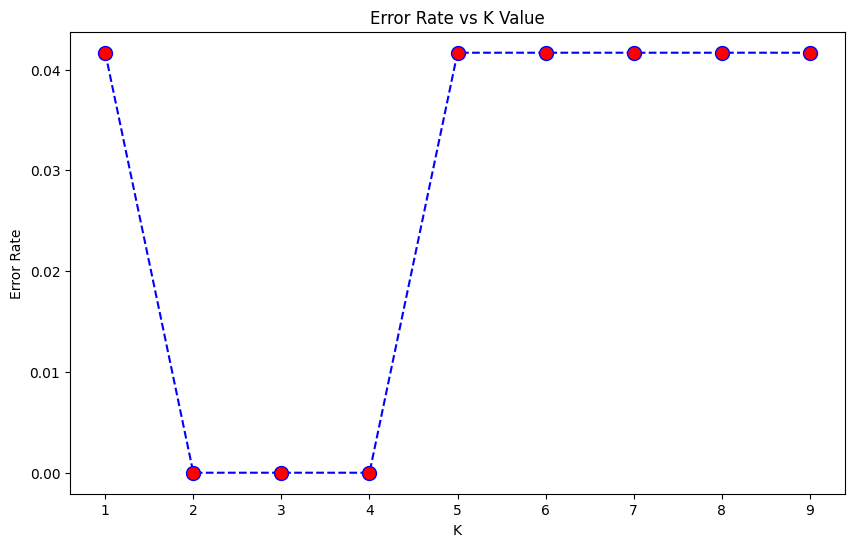

In [48]:
# PLotting K v/s error rate
error_rate=[]
for i in range(1,10):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i=knn.predict(X_test)
    error_rate.append(np.mean(pred_i!=y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [49]:
# Training KNN classifier
knn=KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)

#Predicting the The Test Data with model
y_pred_knn=knn.predict(X_test)

In [50]:
# accuracy on train and test balance data
print("The KNN Model accuracy on train data - ", knn.score(X_train, y_train))
print("The KNN Model accuracy on test data - ", knn.score(X_test, y_test))

The KNN Model accuracy on train data -  1.0
The KNN Model accuracy on test data -  1.0


In [51]:
#Confusion Matrix for test Data
plot_confusion_matrix(y_test,y_pred_knn)

In [52]:
# Classification report on the test dataset
print(classification_report(y_test, y_pred_knn, target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         7
React Developer       1.00      1.00      1.00         7
  SQL Developer       1.00      1.00      1.00         4
        workday       1.00      1.00      1.00         6

       accuracy                           1.00        24
      macro avg       1.00      1.00      1.00        24
   weighted avg       1.00      1.00      1.00        24



In [53]:
# Adding the evaluation metrics to the variable
precision_knn = round(precision_score(y_test,y_pred_knn,average = 'macro'),2)
recall_knn = round(recall_score(y_test,y_pred_knn, average = 'macro'),2)
f1_knn = round(f1_score(y_test,y_pred_knn, average = 'macro'),2)
accuracy_test_knn = round(accuracy_score(y_test,y_pred_knn),2)
accuracy_train_knn =knn.score(X_train, y_train)

### Decision tree

In [54]:
#Initialize and train the DecisionTreeClassifier model
DT_model=DecisionTreeClassifier(random_state=42, max_depth=4)
DT_model.fit(X_train,y_train)

#Predicting the The Test Data with model
DT_model_pred=DT_model.predict(X_test)

In [55]:
# checking accuracy on Train & test data
print("The Decision Tree Model accuracy on train data - ", DT_model.score(X_train,y_train))
print("The Decision Tree Model accuracy on test data - ", DT_model.score(X_test,y_test))

The Decision Tree Model accuracy on train data -  1.0
The Decision Tree Model accuracy on test data -  1.0


In [56]:
# Confusion matrix for test data
plot_confusion_matrix(y_test,DT_model_pred)

In [57]:
# Classification Report for test Data
print(classification_report(y_test,DT_model_pred,target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         7
React Developer       1.00      1.00      1.00         7
  SQL Developer       1.00      1.00      1.00         4
        workday       1.00      1.00      1.00         6

       accuracy                           1.00        24
      macro avg       1.00      1.00      1.00        24
   weighted avg       1.00      1.00      1.00        24



In [58]:
# Adding the evaluation metrics to the variable
precision_dt = round(precision_score(y_test,DT_model_pred,average = 'macro'),2)
recall_dt = round(recall_score(y_test,DT_model_pred, average = 'macro'),2)
f1_dt = round(f1_score(y_test,DT_model_pred, average = 'macro'),2)
accuracy_test_dt = round(accuracy_score(y_test,DT_model_pred),2)
accuracy_train_dt =DT_model.score(X_train, y_train)

### SVM

In [59]:
# Create the SVM classifier
svc_model = SVC()

# Train the classifier
svc_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svc_model.predict(X_test)

In [60]:
# checking accuracy on Train & test data
print("The SVM Model accuracy on train data - ", svc_model.score(X_train,y_train))
print("The SVM Model accuracy on test data - ", svc_model.score(X_test,y_test))

The SVM Model accuracy on train data -  1.0
The SVM Model accuracy on test data -  0.875


In [61]:
# Confusion matrix for test data
plot_confusion_matrix(y_test,y_pred_svm)

In [62]:
# Classification Report for test Data
print(classification_report(y_test,y_pred_svm,target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      0.86      0.92         7
React Developer       0.70      1.00      0.82         7
  SQL Developer       1.00      0.50      0.67         4
        workday       1.00      1.00      1.00         6

       accuracy                           0.88        24
      macro avg       0.93      0.84      0.85        24
   weighted avg       0.91      0.88      0.87        24



In [63]:
# Adding the evaluation metrics to the variable
precision_svm = round(precision_score(y_test,y_pred_svm,average = 'macro'),2)
recall_svm = round(recall_score(y_test,y_pred_svm, average = 'macro'),2)
f1_svm = round(f1_score(y_test,y_pred_svm, average = 'macro'),2)
accuracy_test_svm = round(accuracy_score(y_test,y_pred_svm),2)
accuracy_train_svm =svc_model.score(X_train, y_train)

### XGBoost Classifier

In [64]:
# Create the XGBoost classifier
xg_boost_model = XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)

# Train the classifier
xg_boost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgc = xg_boost_model.predict(X_test)

In [65]:
# checking accuracy on Train & test data
print("The XGBoost Model accuracy on train data - ", xg_boost_model.score(X_train,y_train))
print("The XGBoost Model accuracy on test data - ", xg_boost_model.score(X_test,y_test))

The XGBoost Model accuracy on train data -  1.0
The XGBoost Model accuracy on test data -  1.0


In [66]:
# Confusion matrix for test data
plot_confusion_matrix(y_test,y_pred_xgc)

In [67]:
# Classification Report for test Data
print(classification_report(y_test,y_pred_xgc,target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      1.00      1.00         7
React Developer       1.00      1.00      1.00         7
  SQL Developer       1.00      1.00      1.00         4
        workday       1.00      1.00      1.00         6

       accuracy                           1.00        24
      macro avg       1.00      1.00      1.00        24
   weighted avg       1.00      1.00      1.00        24



In [68]:
# Adding the evaluation metrics to the variable
precision_xgc = round(precision_score(y_test,y_pred_xgc,average = 'macro'),2)
recall_xgc = round(recall_score(y_test,y_pred_xgc, average = 'macro'),2)
f1_xgc = round(f1_score(y_test,y_pred_xgc, average = 'macro'),2)
accuracy_test_xgc = round(accuracy_score(y_test,y_pred_xgc),2)
accuracy_train_xgc =xg_boost_model.score(X_train, y_train)

## Logistic Regression

In [69]:
# Initialize Logistic Regression with One-vs-Rest strategy
logistic_model = OneVsRestClassifier(LogisticRegression(max_iter=500, random_state=42))

# Fit the model to the training data
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logistic_model.predict(X_test)

In [70]:
# checking accuracy on Train & test data
print("The Logistic Regression Model accuracy on train data - ", logistic_model.score(X_train,y_train))
print("The Logistic Regression accuracy on test data - ", logistic_model.score(X_test,y_test))

The Logistic Regression Model accuracy on train data -  1.0
The Logistic Regression accuracy on test data -  0.875


In [71]:
# Confusion matrix for test data
plot_confusion_matrix(y_test,y_pred)

In [72]:
# Classification Report for test Data
print(classification_report(y_test,y_pred,target_names=['Peoplesoft','React Developer','SQL Developer','workday']))

                 precision    recall  f1-score   support

     Peoplesoft       1.00      0.86      0.92         7
React Developer       0.70      1.00      0.82         7
  SQL Developer       1.00      0.50      0.67         4
        workday       1.00      1.00      1.00         6

       accuracy                           0.88        24
      macro avg       0.93      0.84      0.85        24
   weighted avg       0.91      0.88      0.87        24



In [73]:
# Adding the evaluation metrics to the variable
precision_LRM = round(precision_score(y_test,y_pred,average = 'macro'),2)
recall_LRM = round(recall_score(y_test,y_pred, average = 'macro'),2)
f1_LRM = round(f1_score(y_test,y_pred, average = 'macro'),2)
accuracy_test_LRM = round(accuracy_score(y_test,y_pred),2)
accuracy_train_LRM =logistic_model.score(X_train, y_train)

### Model Evaluation

In [74]:
evaluation = {"Models":["KNN Classifier","DecisionTree Classifier","RandomForest Classifier","SVM Classifier",
                        "XGBoost Classifier","Naive Bayes Classifier","Logistic Regression"],\
            "Train_Accuracy":[accuracy_train_knn,accuracy_train_dt,accuracy_train_rf,accuracy_train_svm,accuracy_train_xgc,accuracy_train_nb,accuracy_train_LRM],
            "Test_Accuracy":[accuracy_test_knn,accuracy_test_dt,accuracy_test_rf,accuracy_test_svm,accuracy_test_xgc,accuracy_test_nb,accuracy_test_LRM],\
            "Precision":[precision_knn,precision_dt,precision_rf,precision_svm,precision_xgc,precision_nb,precision_LRM],\
            "Recall":[recall_knn,recall_dt,recall_rf,recall_svm,recall_xgc,recall_nb,recall_LRM],\
            "F1-Score":[f1_knn,f1_dt,f1_rf,f1_svm,f1_xgc,f1_nb,f1_LRM]}
evaluation = pd.DataFrame(evaluation)
evaluation

,Models,Train_Accuracy,Test_Accuracy,Precision,Recall,F1-Score
0,KNN Classifier,1.0,1.00,1.00,1.00,1.00
1,DecisionTree Classifier,1.0,1.00,1.00,1.00,1.00
2,RandomForest Classifier,1.0,1.00,1.00,1.00,1.00
3,SVM Classifier,1.0,0.88,0.92,0.84,0.85
4,XGBoost Classifier,1.0,1.00,1.00,1.00,1.00
5,Naive Bayes Classifier,1.0,0.83,0.90,0.78,0.77
6,Logistic Regression,1.0,0.88,0.92,0.84,0.85


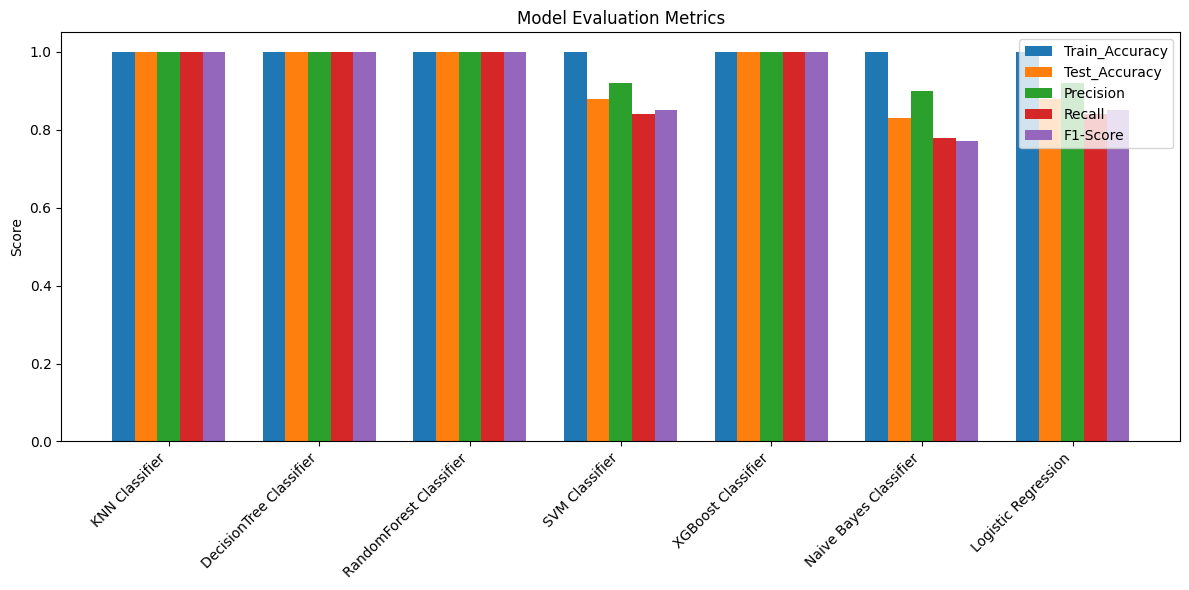

In [75]:
# Setting the figure size
plt.figure(figsize=(12,6))

# Plotting each metric
metrics = ["Train_Accuracy", "Test_Accuracy", "Precision", "Recall", "F1-Score"]
x = range(len(evaluation["Models"]))

for i, metric in enumerate(metrics):
    # Calculate the bar positions
    bar_positions = [p + i * 0.15 for p in x]
    
    # Create the bars without adding the text labels
    bars = plt.bar(bar_positions, evaluation[metric], width=0.15, label=metric)

# Configure plot
plt.xticks([p + 0.3 for p in x], evaluation["Models"], rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Model Evaluation Metrics")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

***Out of all 7 models, we have got 4 models with best Accuracy score i.e, 1.00 are as follows :***

 **- KNN**
 
 **- DECISION TREE**
 
 **- RANDOM FOREST**
 
 **- XGBOOST**
 

In [77]:
# taking a pickle dump of the random forest
pickle.dump(rf_clf, open("artifacts/rf_clf.pkl", "wb"))